In [1]:
from common.kmeans_clustering_func import *

### Perform the k-means clustering

In [2]:
lists = np.load('./data/deformation_analysis.npz',allow_pickle=True)
mapping = np.load('./data/map.npz')

nuclei_true = mapping['nuclei']
lists_array = lists['aspect_axis_change']

In [3]:
df_change_lists = make_particle_change_lists(lists_array, num_list=True)
selected_lists, original_p_n_lists, modified_p_n_lists = modify_change_lists(df_change_lists, 1000, -1000) ## you can set the threshold to exclude unreasonable change rate
nuclei_true_trans = transform_nuclei_true(nuclei_true, original_p_n_lists, modified_p_n_lists)

100%|███████████████████████████████████| 5272/5272 [00:00<00:00, 145229.61it/s]


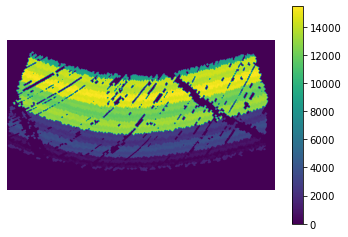

In [7]:
im=plt.imshow(nuclei_true_trans)
plt.axis('off')
plt.colorbar(im)

In [8]:
df_mod = pd.DataFrame(selected_lists)
num_clusters = 8
HR_kmeans = KMeans(n_clusters=num_clusters, random_state=0)
HR_model = HR_kmeans.fit(df_mod.iloc[:,1:])
HR_kmeans_result = HR_model.predict(df_mod.iloc[:,1:])

In [9]:
HR_kmeans_map = result_visualization_kmeans(nuclei_true_trans, HR_kmeans_result)

In [10]:
HR_SS = np.load('./data/strain_stress.npz')
strain_hr1 = HR_SS['strain']
stress_hr1 = HR_SS['stress']

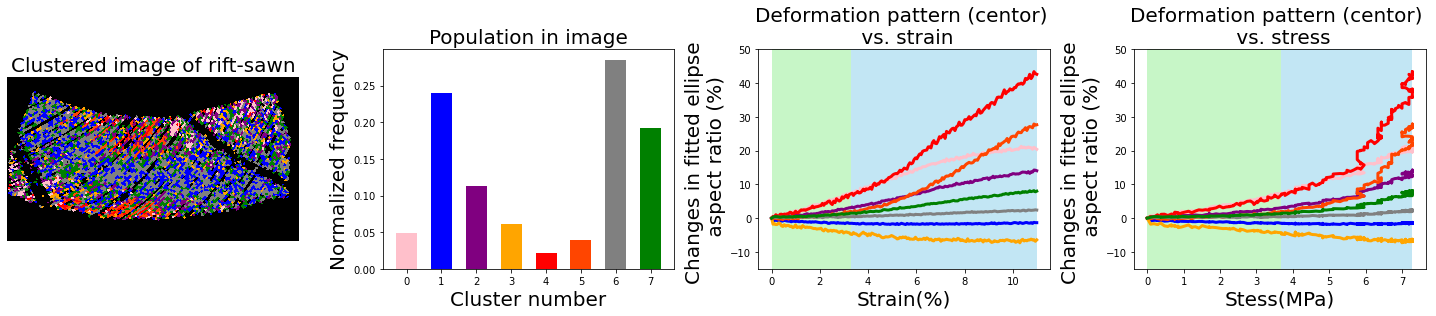

In [11]:
colors = ["gray", "blue", "green", "purple", "orange", "pink", "orangered","red"]

def sort_colorlist(c_order,colorlist):
    clist = ['a']*len(colorlist)
    for k in range(len(clist)):
        clist[c_order[k]]= colorlist[k]
    return clist

interval = np.arange(-.5,8,1)
HR_order, _=np.histogram(HR_kmeans_result, bins=num_clusters)
HR_c_order=np.argsort(HR_order)[::-1]
HR_adj_colorlist=sort_colorlist(HR_c_order,colors)

HR_cmap = ListedColormap(HR_adj_colorlist, name="custom")
HR_cmap.set_bad("black")

fig, ax = plt.subplots(1,4, figsize=(20,4.5))#figsize=(20,4.5)

ax[0].pcolormesh(np.ma.array(HR_kmeans_map[:,:], mask=nuclei_true_trans[:,:]==0), cmap = HR_cmap)
ax[0].axis('off')
ax[0].set_title('Clustered image of rift-sawn', fontsize=20)
ax[0].invert_yaxis()
ax[0].set_aspect('equal')
#ax[0].text(-0.1, 1.1,'(a)', fontsize=30)

for i in range(len(HR_kmeans.cluster_centers_)):
    ax[2].plot(strain_hr1[:-11]*100, HR_kmeans.cluster_centers_[i],c=HR_adj_colorlist[i],linewidth=3)
ax[2].axvspan(0, strain_hr1[56]*100, facecolor='lightgreen', alpha=0.5)
ax[2].axvspan(strain_hr1[56]*100, strain_hr1[-12]*100, facecolor='skyblue', alpha=0.5)
ax[2].set_title('Deformation pattern (centor) \n vs. strain', fontsize=20)
ax[2].set_xlabel('Strain(%)', fontsize=20)
ax[2].set_ylabel('Changes in fitted ellipse \n aspect ratio (%)', fontsize=20)
ax[2].set_ylim(-15,50)
#ax[2].text(-200, -200,'(g)', fontsize=30)

for i in range(len(HR_kmeans.cluster_centers_)):
    ax[3].plot(stress_hr1[:-11], HR_kmeans.cluster_centers_[i],c=HR_adj_colorlist[i],linewidth=3)
ax[3].axvspan(0, stress_hr1[56], facecolor='lightgreen', alpha=0.5)
ax[3].axvspan(stress_hr1[56], np.max(stress_hr1), facecolor='skyblue', alpha=0.5)
ax[3].set_title('Deformation pattern (centor) \n vs. stress', fontsize=20)
ax[3].set_xlabel('Stess(MPa)', fontsize=20)
ax[3].set_ylabel('Changes in fitted ellipse \n aspect ratio (%)', fontsize=20)
ax[3].set_ylim(-15,50)
ax[3].set_xlim()
#ax[3].text(-200, -200,'(j)', fontsize=30)

#
n, bins, patches = ax[1].hist(HR_kmeans_result, bins=interval, rwidth=0.6, density=True)
for i in range(num_clusters):
    patches[i].set_facecolor(HR_adj_colorlist[i])
ax[1].set_title('Population in image', fontsize=20)
ax[1].set_xlabel('Cluster number',fontsize=20)
ax[1].set_ylabel('Normalized frequency', fontsize=20)
#ax[1].text(-200, 100,'(d)', fontsize=30)

fig.tight_layout()